## Title: Binary Classification ML model
Author: Yiran Jing

Date: 26-06-2019


**DataSet description**

- This datatset contain 19 features: 3 continuous variables, 16 categorical variables. 
- Our target is **Churn** (yes or no).
- 7021 customers (each customer has uniqte customerId each row) after remove duplicates. 


### Summary
**XGboost** has the best performance compared to Logistic and Randomforest. 

After cleaning data and boxCox transformation, we have 30 features to train model
- Logistic model (threshold 0.5): accuracy: 0.797, precision: 0.86,recall: 0.87, f1: 0.86
- XGboost model: **accuracy: 0.803, precision: 0.84, recall: 0.91, f1: 0.87**



### Steps within this notebook
1. **Variable selection**

We want to select the most relevant features to predict customer Churn. Lacking other supported information, My decision is based on the following information:

a) Intuitive thinking

b) The table and plots (continuous and categorical variables)

c) Correlation between target and three continuous variables

2. **Data Clearning**

a) Fill average for the missing points 

b) Remove duplicate rows

c) Convert categorical to numerical variables

d) Split dataset (80% training data)

e) Correlation check and justification among features.

f) BoxCox transformation for continuous variable TotalCharges

3. Benchmark: Logistic model
4. **ML model: XGBoost**

Trunning hyperPartameter by **GridSearchCV**, with CV = 5. score by **average_precision**

In [156]:
import boto3
import pandas as pd
import pyspark
from sagemaker import get_execution_role
from datetime import datetime
from pyspark.sql import SQLContext
import os.path 
import datetime
pd.set_option('display.max_columns', 500)
import seaborn as sns
import numpy as np
import calendar
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, SVR
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.externals import joblib
from scipy.stats import norm, skew
import statsmodels.api as sm
blue = sns.color_palette('Blues')[-2]
color = sns.color_palette() 
sns.set_style('darkgrid') 
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points
import nltk
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
role = get_execution_role()

#### Load Dataset

In [160]:
row_data = 's3://taysolsdev/datasets/Telco-Customer-Churn.csv'
df = pd.read_csv(row_data, encoding = "ISO-8859-1")
df = df.set_index('customerID') # we set customerId as index
df.head(2)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850,29.85,No
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950,1889.5,No


In [133]:
df.shape # 20 columns: 19 predictors, 3 continues variables, 16 categorical variables.

(7043, 20)

In [159]:
print ("\nUnique values :  \n", df.nunique())


Unique values :  
 gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64


In [134]:
df = df.convert_objects(convert_numeric=True) # since TotalCharges initially is tring type

##### The step below decreased the model performance and so not considered in final dataset. 
#### Combine classes of some binary variables 
In many columns there are duplicate values i.e. 'no' and 'no phone service' which both mean the same thing. For example, in MultipleLines column there are three class: 'No', 'No phone service' and 'Yes'. We combine 'No phone service' to "No", since they are the same thing. 

Other columns were OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies.

## Step 1: variable selection
Firstly, I want to select the most relevant variables related to customer churn. Lacking other background information, I drawed plot to see if these variables are relavent to customer Churn.

We have two kinds of variables in this dataset: 

- continuous variables: there are only three: 'tenure','MonthlyCharges','TotalCharges', we keep all of them to train model. Since the distribution of these three (transformed) variables (see boxCox transformation) all looks normal-like or uniform like. Also, intuitively, these three variables should be quite relavent to customer churn. Note that the **Point biserial correlation** between target and these three continuous variables are not high (around 0.2), but keep in mind that it is just linear relationship, which means that we can **find better model than simple logistic regression** [what you are saying here is that correlation is not the only way to predict churn?]



- categoraical variables: there are 16 categorial variables (only two or three classes for each of them)

From the tables and plots below, it seems like:
1. gender might not be important to forecast Churn, but we still keep it as binary variables in the modelling, since **different gender generally could affect customers' decision and consumer behavors**.
2. MultipleLines, and PhoneService might also be not relevant. but we still keep them in the model.
3. Other categorical variables seem relative to Churn(detailed discussions are below the plots), so I decide to use all of them in model.

#### Plots of Categoraical variables

gender  Female  Male
Churn               
No        2549  2625
Yes        939   930
--------------------------------------------------


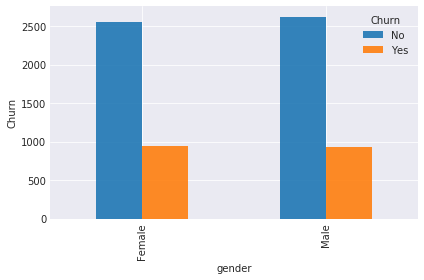

SeniorCitizen     0    1
Churn                   
No             4508  666
Yes            1393  476
--------------------------------------------------


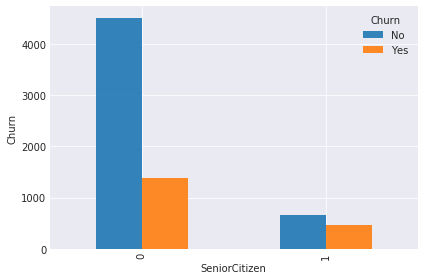

Partner    No   Yes
Churn              
No       2441  2733
Yes      1200   669
--------------------------------------------------


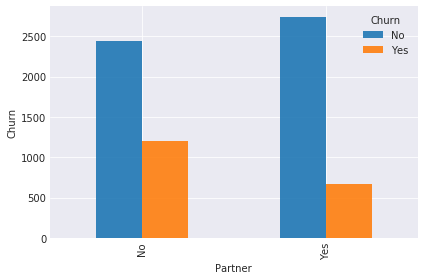

Dependents    No   Yes
Churn                 
No          3390  1784
Yes         1543   326
--------------------------------------------------


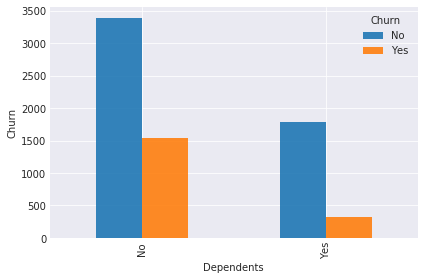

PhoneService   No   Yes
Churn                  
No            512  4662
Yes           170  1699
--------------------------------------------------


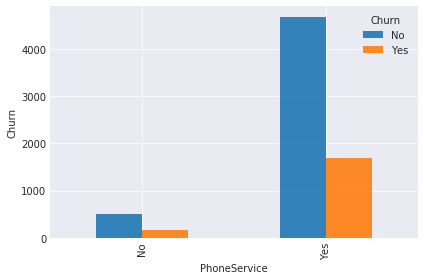

MultipleLines    No  No phone service   Yes
Churn                                      
No             2541               512  2121
Yes             849               170   850
--------------------------------------------------


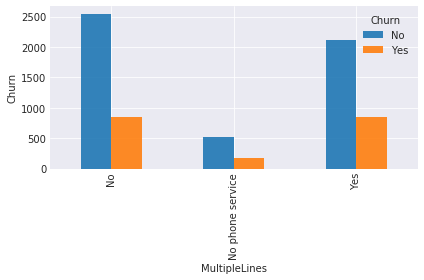

InternetService   DSL  Fiber optic    No
Churn                                   
No               1962         1799  1413
Yes               459         1297   113
--------------------------------------------------


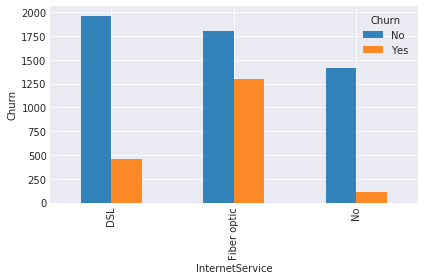

OnlineSecurity    No  No internet service   Yes
Churn                                          
No              2037                 1413  1724
Yes             1461                  113   295
--------------------------------------------------


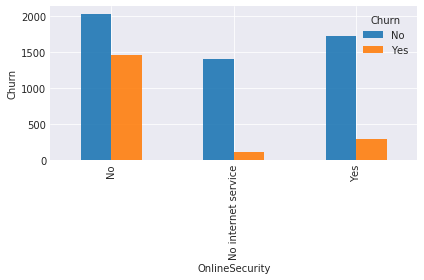

OnlineBackup    No  No internet service   Yes
Churn                                        
No            1855                 1413  1906
Yes           1233                  113   523
--------------------------------------------------


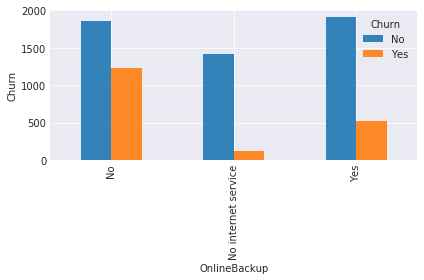

DeviceProtection    No  No internet service   Yes
Churn                                            
No                1884                 1413  1877
Yes               1211                  113   545
--------------------------------------------------


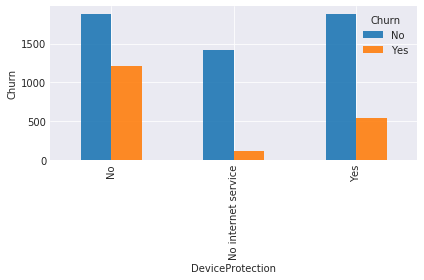

TechSupport    No  No internet service   Yes
Churn                                       
No           2027                 1413  1734
Yes          1446                  113   310
--------------------------------------------------


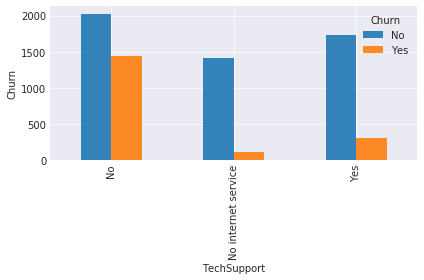

StreamingTV    No  No internet service   Yes
Churn                                       
No           1868                 1413  1893
Yes           942                  113   814
--------------------------------------------------


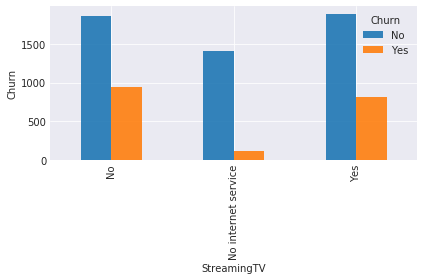

StreamingMovies    No  No internet service   Yes
Churn                                           
No               1847                 1413  1914
Yes               938                  113   818
--------------------------------------------------


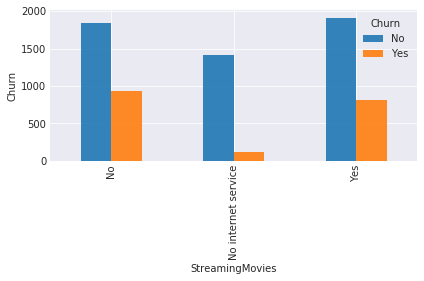

Contract  Month-to-month  One year  Two year
Churn                                       
No                  2220      1307      1647
Yes                 1655       166        48
--------------------------------------------------


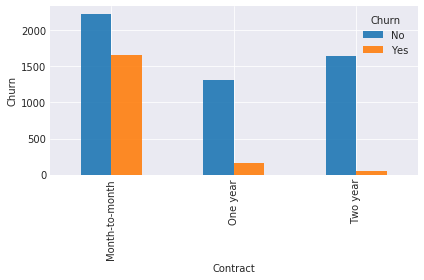

PaperlessBilling    No   Yes
Churn                       
No                2403  2771
Yes                469  1400
--------------------------------------------------


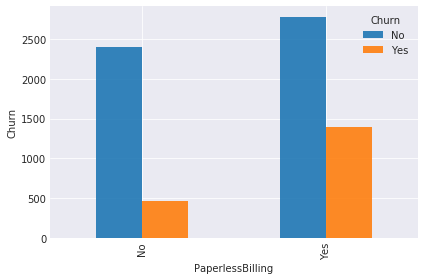

PaymentMethod  Bank transfer (automatic)  Credit card (automatic)  \
Churn                                                               
No                                  1286                     1290   
Yes                                  258                      232   

PaymentMethod  Electronic check  Mailed check  
Churn                                          
No                         1294          1304  
Yes                        1071           308  
--------------------------------------------------


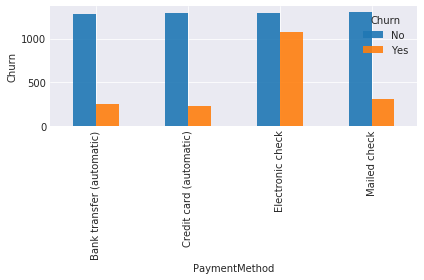

In [135]:
colours=['#1F77B4', '#FF7F0E']

for column in df.columns[:-1]: # the last column is response
    if column != 'tenure' and column != 'MonthlyCharges' and column != 'TotalCharges':
        table=pd.crosstab(df["Churn"],df[column])
        print(table)
        print("--------------------------------------------------")
        fig, ax = plt.subplots()
        (table.T).plot(kind='bar', alpha=0.9, color=colours, ax=ax)
        ax.set_xlabel(column)
        ax.set_ylabel('Churn')
        plt.tight_layout()
        sns.despine()
        plt.show()
        

- **Gender** seems no relationship with customer churn, as the patterns of Female class and Male class look quite simiar, so gender potentially has no relationship with churn.
- **PhoneService** Note quite relevant to customer churn. Given customers have PhoneService, the percentage of chrun is 0.267 (1699/(1699+4662)). Given customers dnnot have  PhoneService, the percentage of chrun is 0.25 (170/(170+512)). 0.25 is quite simiar with 0.267. 
- **MultipleLines** Note quite relevant to customer churn. Since The percentage of churn of three classes are: 0.25(1019/(1019+3053)),0.25, and 0.286(850/(2121+850)).
- **Partner** some difference between No and Yes class. From plots we can see that, if customer have partner, then less likely to churn, compared to the customers without parnter.
- **Other Features** They all **show apparent different churn patterns within each class**,similar interpretation with Partner. 

## Step 2: Clean data

### Check missing value
missing value in totalCharges, I replace nan values with average of that column

In [136]:
# if sum >0, it means missing value
df.isnull().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [137]:
df['TotalCharges'].fillna((df['TotalCharges'].mean()), inplace=True)

### Drop duplicate rows

In [138]:
print(len(df)) # initial 
df = df.drop_duplicates()
print(len(df)) # after removing duplicates

7043
7021


### Check duplicate columns
Only three numerical columns, so easy to check 

no duplicate columns

### Convert categorical variable to numberical variable
- For the binary variables with only two classes (yes / no), I convert it to another one binary column with 0 and 1 only. For example,  'Partner' column has two value (yes or no), I convert it to 
\begin{equation}
\label{eqn:dummy_3}
Partner\_Yes = 
  \begin{cases}
	1 & \text{if has partner} \\
    0 & \text{no partner}
  \end{cases}
\end{equation}

- For multi-class variables with three/four classes, I canvert it to another two binary columns. For example, Contract has thress possible values: 'Month-to-month', 'One year' and 'Two year'. The converted columns are:
\begin{equation}
\label{eqn:dummy_1}
Contract\_One year = 
  \begin{cases}
	1 & \text{if contract is one year} \\
    0 & \text{otherwise}
  \end{cases}
\end{equation}

\begin{equation}
\label{eqn:dummy_1}
Contract\_Two year = 
  \begin{cases}
	1 & \text{if contract is two year} \\
    0 & \text{otherwise}
  \end{cases}
\end{equation}

i.e. if one row has 0 in both contract_oneyear and contract_twoyear, this means that it is 'Month-to-month' contract.

In [139]:
df = pd.get_dummies(df, drop_first=True) 

In [140]:
df.head(2)

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
customerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,0,1,29.850,29.850,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
5575-GNVDE,0,34,56.950,1889.500,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0


In [141]:
df.shape # now we have 24 columns, i.e. 30 features

(7021, 31)

### Split dataset
training dataset 70%, test dataset 30%. 

In [142]:
target_y = df['Churn_Yes']
features_x = df.loc[:, df.columns != 'Churn_Yes']

X_train, X_test, y_train, y_test = train_test_split(features_x, target_y, test_size=0.3)  # split dataset 80%

### Correlation
#### Correlation Matrix among continuous variables
The **purpose** for this section is to check if three continuous variables('tenure', 'MonthlyCharges', 'TotalCharges') have quite simiar information with each other, i.e. **Collinearity**(a condition in which some of the independent variables are highly correlated) might be a problem in statistical modelling, and can also worse the performance of ML models.

If some columns are quite high correlatied, we need to consider combining them or delete some columns. From the correlation matrix below, we can see that these three variables have quite different correlations with each other. So there is no collinearity issues and it is better to keep all three variables in the modelling. 

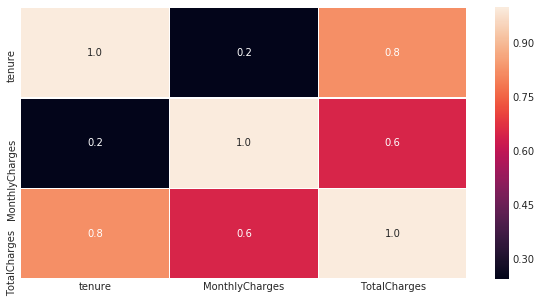

In [143]:
#Since intuitively, these feastures should be most useful
X = df[['tenure', 'MonthlyCharges', 'TotalCharges']]

## correlation of selected features
f,ax = plt.subplots(figsize=(10, 5))
sns.heatmap(X.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

#### Point biserial correlation between target and three continuous variables
The point biserial correlation is used to measure the relationship between a binary variable, y, and a continuous variable, x. this one varies between -1 and +1 with 0 implying no correlation. Correlations of -1 or +1 imply a determinative relationship.

Based on the calculation below, the linear correlation between target and these three variables are not high (statistical significant since P_values are less than 0.01). Keep this in mind, since it might give us insight to improve model further.

In [144]:
from scipy import stats

for feature in X_train[['tenure', 'MonthlyCharges', 'TotalCharges']].columns: # remove gender
    print('Churn with {} is {}'.format(feature, stats.pointbiserialr(y_train, X_train[feature])))
    

Churn with tenure is PointbiserialrResult(correlation=-0.35710712006245193, pvalue=9.809105333441288e-148)
Churn with MonthlyCharges is PointbiserialrResult(correlation=0.20060144427682391, pvalue=8.755601208712716e-46)
Churn with TotalCharges is PointbiserialrResult(correlation=-0.1971012988821942, pvalue=3.131483021569794e-44)


### BoxCox transformation for continuous variables
Data transformation is not important for ML models, but useful in (statistical) logistic model (Baseline). 

The **reasoning** for data transformation is: we prefer more symmetric distribution in the statistical modelling, such as normal or uniform distribution. 

Note that since we cannot find good symmetric distribution after tring data transformation. So logistic model might not have good performance, compared to more flexible ML models.

- 'TotalCharges' is right-skewed, and boxCox transformation is much better than Log transformation. Thus we do boxCox transform for it
- 'MonthlyCharges' have little improvements after transformation, so keep it original
- "tenure" looks like uniform dist, so it is fine.

In [145]:
# three continuous variables in dataset
X_train[['tenure','MonthlyCharges','TotalCharges']].describe()

,tenure,MonthlyCharges,TotalCharges
count,4914.000,4914.000,4914.000
mean,32.602,64.674,2279.738
std,24.506,29.963,2241.781
min,0.000,18.400,18.850
25%,9.000,35.450,416.412
50%,29.000,70.400,1413.600
75%,56.000,89.700,3793.175
max,72.000,118.750,8684.800


In [146]:
from scipy import stats
def bonxcox_transf(data):
    y, lmbda=stats.boxcox(data)
    output=((data**lmbda - 1) / lmbda)
    print("The lmbda is: "+str(lmbda))
    del data # must delete old one, and remember to mention it in report
    return output 

def log_transf(data):
    output=np.log(data)
    return output

# firstly we define a function to simply the following code process
def distribution_histor_Q_Qplot(predictor, column1, column2, column3):
    fig, ax= plt.subplots(2,3, figsize=(18,10))
    sns.distplot(column1 , fit=norm,ax=ax[0,0]);(mu, sigma) = norm.fit(column1)
    ax[0,0].legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
                loc='best')
    ax[0,0].set(title='Historgam of '+predictor, xlabel=predictor,ylabel='Frequency')
    
    pp = sm.ProbPlot(column1, fit=True)
    qq = pp.qqplot(color=sns.color_palette('Blues')[-1], alpha=0.8, ax=ax[1,0])
    a=ax[1,0].get_xlim()[0]
    b=ax[1,0].get_xlim()[1]
    ax[1,0].plot([a,b],[a,b], color='black', alpha=0.6)
    ax[1,0].set_xlim(-6,6)
    ax[1,0].set_ylim(-6,6)
    ax[1,0].set_title('Normal Q-Q plot for the '+predictor)
    
    sns.distplot(column2 , fit=norm,ax=ax[0,1]);
    (mu, sigma) = norm.fit(column2)
    ax[0,1].set(title='Historgam of '+predictor+' after LOG transformation', xlabel=predictor,ylabel='Frequency')
    ax[0,1].legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
                loc='best')
    pp = sm.ProbPlot(column2, fit=True)
    qq = pp.qqplot(color=sns.color_palette('Blues')[-1], alpha=0.8, ax=ax[1,1])
    a=ax[1,1].get_xlim()[0]
    b=ax[1,1].get_xlim()[1]
    ax[1,1].plot([a,b],[a,b], color='black', alpha=0.6)
    ax[1,1].set_xlim(-6,6)
    ax[1,1].set_ylim(-6,6)
    ax[1,1].set_title('Normal Q-Q plot for the '+predictor+' after LOG transformation')
    
    sns.distplot(column3 , fit=norm,ax=ax[0,2]);
    (mu, sigma) = norm.fit(column3)
    ax[0,2].set(title='Historgam of '+predictor+' after boxCox transformation', xlabel=predictor,ylabel='Frequency')
    ax[0,2].legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
                loc='best')
    pp = sm.ProbPlot(column3, fit=True)
    qq = pp.qqplot(color=sns.color_palette('Blues')[-1], alpha=0.8, ax=ax[1,2])
    a=ax[1,2].get_xlim()[0]
    b=ax[1,2].get_xlim()[1]
    ax[1,2].plot([a,b],[a,b], color='black', alpha=0.6)
    ax[1,2].set_xlim(-6,6)
    ax[1,2].set_ylim(-6,6)
    ax[1,2].set_title('Normal Q-Q plot for the '+predictor+' after boxCox transformation')
    
    plt.show()

#### MonthlyCharges

The lmbda is: 0.925304074555285


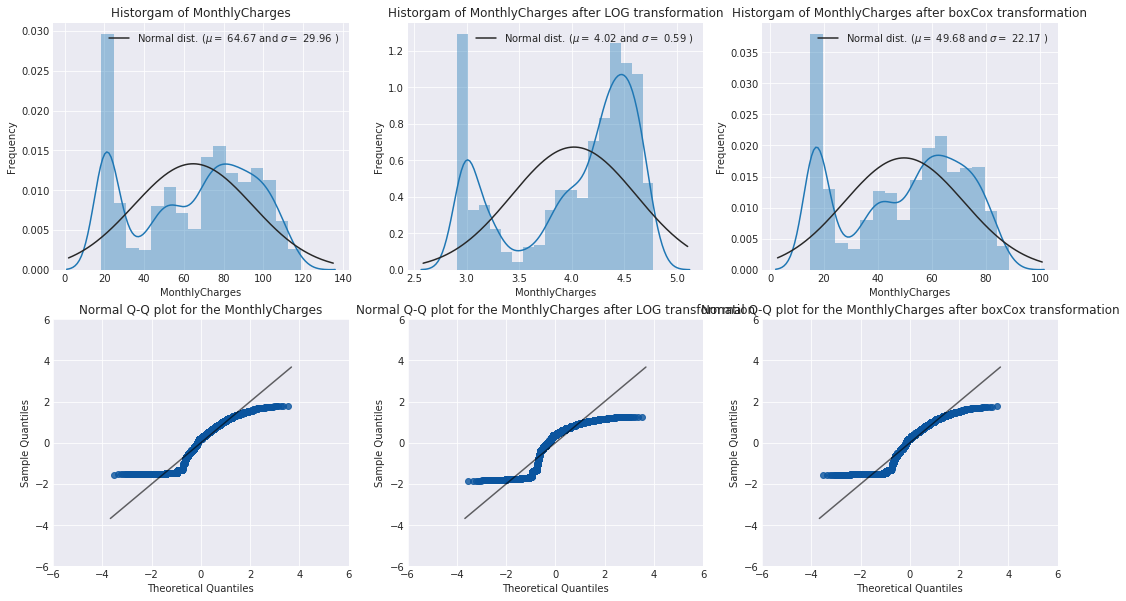

In [147]:
#df['Log_MonthlyCharges']=log_transf(df['MonthlyCharges']) 
distribution_histor_Q_Qplot('MonthlyCharges', X_train['MonthlyCharges'], log_transf(X_train['MonthlyCharges']), 
                            bonxcox_transf(X_train['MonthlyCharges']))

- The first row is historgam distributions of MonthlyCharges, after log transfomrtion and after boxCox transformation. The blue line in the historgam plot is the **actual fitted line** based on the historgam distribution, and the black line is normal distribution given the same mean and standard derivation of Monthlycharges. 

- The second row is the Normal QQ plot before and after data transformation. The X is theoretical normal distribution, and Y is actually data distribution. If the two distributions being compared are similar, the points in the Q–Q plot will approximately lie on the line y = x. 

Compared the blue line and black line in the histogram and QQ plot, we can see that the actual distribution is quite different from the normal distribution, and data transfomration doesnot work here. But since the original distribution looks not quite bad, we use the original data in the modelling. 

#### TotalCharges

The lmbda is: 0.26066369917777704


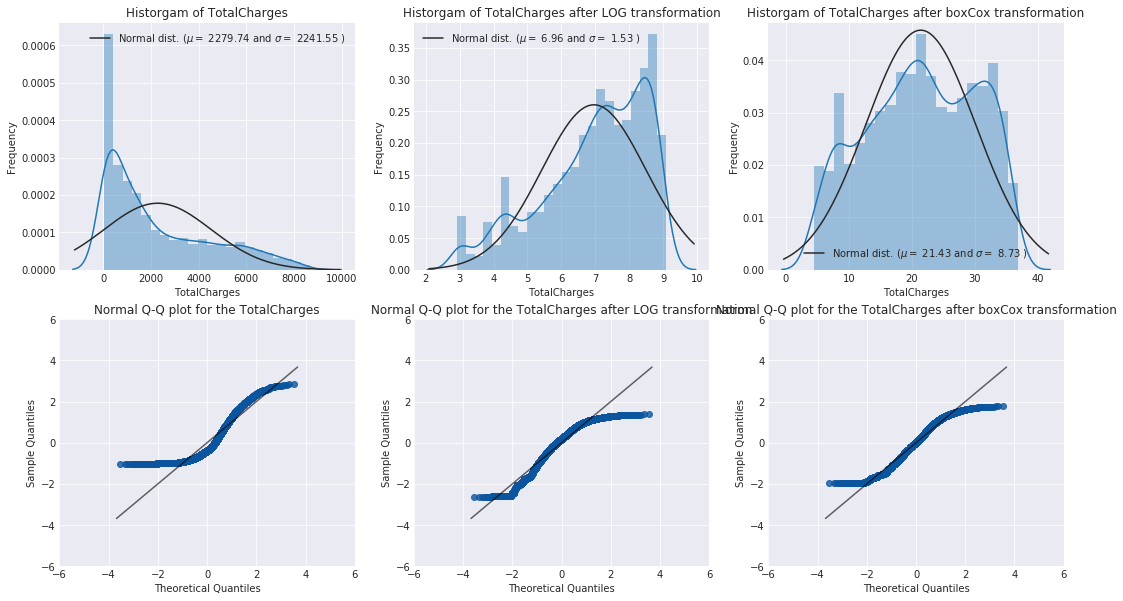

In [148]:
distribution_histor_Q_Qplot('TotalCharges', X_train['TotalCharges'], log_transf(X_train['TotalCharges']), 
                            bonxcox_transf(X_train['TotalCharges']))

Compared the blue line and black line in the histogram and QQ plot, we can see that the actual distribution is quite different from the normal distribution, and boxCox transformation makes the totalCharges more symmetry. Thus we apply  boxCox transformation to the TotalCharges and use this new column in the modelling.

In [149]:
# we overwirte original columns
X_train['TotalCharges'] = bonxcox_transf(X_train['TotalCharges'])
X_test['TotalCharges'] = bonxcox_transf(X_test['TotalCharges']) 

The lmbda is: 0.26066369917777704
The lmbda is: 0.24580188821449397


#### tenure

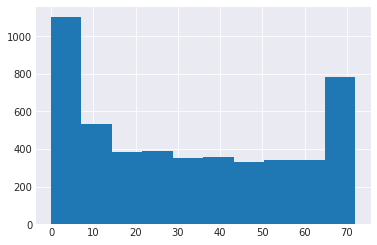

In [150]:
# looks like uniform-distributed. So it is fine. 
X_train['tenure'].hist()

tenure looks like uniform dist, so it is fine.

### Save the new dataset to S3 
Amazon SageMaker XGBoost can train on data in either a CSV or LibSVM format. For this example, we use CSV. It should have the following:

- Have the predictor variable in the first column
- Not have a header row
- We need train(70%), validation(20%), test(10%) *three dataset*

In [151]:
# since first column is target for SageMaker XGBoost
def shift_last_column_to_first(df):
    cols = list(df.columns)
    cols = [cols[-1]] + cols[:-1]
    df = df[cols]
    return df

In [152]:
df['TotalCharges'] = bonxcox_transf(df['TotalCharges'])
df = shift_last_column_to_first(df)

train_data, validation_data, test_data = np.split(df.sample(frac=1, random_state=1729), [int(0.7 * len(df)), int(0.9 * len(df))])
train_data.to_csv('train.csv', header=False, index=False)
validation_data.to_csv('validation.csv', header=False, index=False)
test_data.to_csv('test.csv', header=False, index=False)

The lmbda is: 0.25614406206807805


#### create batch input data(for test)

In [154]:
test_for_batch = test_data.iloc[:, 1:] # delete the target column
test_for_batch.to_csv('test_data_Batch.csv',header=False, index = False)

## Step 3: Training Model
- baseLine: logistic
- ML model: Xgboost (better than random forest)

In [21]:
seed = 960428;
from sklearn.metrics import classification_report
def get_score(y_true,y_pred):
    f1 = metrics.f1_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    accuracy = metrics.accuracy_score(y_true, y_pred)
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
    return precision, recall, f1, accuracy, tn, fp, fn, tp

def runRorestRun (X_train, X_test, y_train, y_test, clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return y_pred, y_test, X_test


In [22]:
def RunModel(X_train, X_test, y_train, y_test, clf):
    y_pred, y_test, X_test = runRorestRun(X_train, X_test, y_train, y_test, clf)

    #get scores
    temp_precision, temp_recall, temp_f1, temp_accuracy, tn, fp, fn, tp = get_score(y_test,y_pred)
    output = [temp_precision,temp_recall,temp_f1,temp_accuracy,tp, fp, tn, fn]
    output = pd.Series(output, index=['precision', 'recall', 'f1', 'accuracy', 'tp', 'fp', 'tn', 'fn']) 
    print(output[['accuracy', 'tp', 'fp', 'tn', 'fn']])
    return y_pred


### Logistic regression
Threshold =0.5 by default

In [36]:
clf = LogisticRegression(random_state=seed, solver='lbfgs')
y_pred = RunModel(X_train, X_test, y_train, y_test, clf)

print(classification_report(y_test, y_pred))

accuracy     0.796
tp         207.000
fp         133.000
tn         911.000
fn         154.000
dtype: float64
              precision    recall  f1-score   support

           0       0.86      0.87      0.86      1044
           1       0.61      0.57      0.59       361

   micro avg       0.80      0.80      0.80      1405
   macro avg       0.73      0.72      0.73      1405
weighted avg       0.79      0.80      0.79      1405



### xgboost
Turning parameter based on RandomizedSearchCV is not helpful, the simple XGBoost given below has the best performance.

#### sinple XGBoost

In [30]:
original_XGBClassifier = xgb.XGBClassifier(learning_rate = 0.02, n_estimators=200, tree_method='hist', 
                                           class_weight='balanced', random_stae=seed)
y_pred = RunModel(X_train, X_test, y_train, y_test, original_XGBClassifier)

print(classification_report(y_test, y_pred))

accuracy     0.803
tp         173.000
fp          89.000
tn         955.000
fn         188.000
dtype: float64
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1044
           1       0.66      0.48      0.56       361

   micro avg       0.80      0.80      0.80      1405
   macro avg       0.75      0.70      0.71      1405
weighted avg       0.79      0.80      0.79      1405



### Appendix: Turning hyperParameter for XGBoost
Score use **average_precision**, CV = 5, use **GridSearch**

#### 1. Fix learning rate and number of estimators for tuning tree-based parameters
In order to decide on boosting parameters, we need to set some initial values of other parameters. 

In [31]:
original_XGBClassifier = xgb.XGBClassifier(learning_rate = 0.02, n_estimators=200, tree_method='hist', 
                                           class_weight='balanced', random_stae=seed)
y_pred = RunModel(X_train, X_test, y_train, y_test, original_XGBClassifier)

print(classification_report(y_test, y_pred))

accuracy     0.803
tp         173.000
fp          89.000
tn         955.000
fn         188.000
dtype: float64
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1044
           1       0.66      0.48      0.56       361

   micro avg       0.80      0.80      0.80      1405
   macro avg       0.75      0.70      0.71      1405
weighted avg       0.79      0.80      0.79      1405



#### Step 2: Tune max_depth and min_child_weight
Based on the result below, It is better to keep the original values.

In [32]:
param_test1 = {
 'max_depth':range(3,10,1),
 'min_child_weight':range(1,6,1)
}

xgb1 = xgb.XGBClassifier(learning_rate = 0.02, n_estimators=200,tree_method='hist', 
                   class_weight='balanced', random_state=seed)

Grid_Search1 = GridSearchCV(estimator = xgb1, param_grid = param_test1, 
                           scoring='average_precision',n_jobs=4,iid=False, cv=5)


Grid_Search1.fit(X_train, y_train)

print('\n Best estimator:')
print(Grid_Search1.best_estimator_)

print('\n Best hyperparameters:')
print(Grid_Search1.best_params_)

clf = Grid_Search1.best_estimator_

y_pred = RunModel(X_train, X_test, y_train, y_test, clf)

print(classification_report(y_test, y_pred))

#### Step 3: Tune gamma
Get the same result with original one. So still use the default value.

In [37]:
param_test2 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

xgb2 = xgb.XGBClassifier(learning_rate = 0.02, n_estimators=200, tree_method='hist', 
                   class_weight='balanced', random_state=seed)

Grid_Search2 = GridSearchCV(estimator = xgb2, param_grid = param_test2, 
                           scoring='average_precision',n_jobs=4,iid=False, cv=5)


Grid_Search2.fit(X_train, y_train)

print('\n Best estimator:')
print(Grid_Search2.best_estimator_)

print('\n Best hyperparameters:')
print(Grid_Search2.best_params_)


clf = Grid_Search2.best_estimator_

y_pred = RunModel(X_train, X_test, y_train, y_test, clf)

print(classification_report(y_test, y_pred))



 Best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', class_weight='balanced',
       colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
       gamma=0.0, learning_rate=0.02, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=960428,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, tree_method='hist', verbosity=1)

 Best hyperparameters:
{'gamma': 0.0}
accuracy     0.803
tp         173.000
fp          89.000
tn         955.000
fn         188.000
dtype: float64
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1044
           1       0.66      0.48      0.56       361

   micro avg       0.80      0.80      0.80      1405
   macro avg       0.75      0.70      0.71      1405
weighted avg       0.79      0.80      0.79      1405



#### Step 4: Tune subsample and colsample_bytree
Same as default value

In [38]:
param_test3 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

xgb2 = xgb.XGBClassifier(learning_rate = 0.02, n_estimators=200, tree_method='hist', 
                   class_weight='balanced', random_state=seed)

Grid_Search3 = GridSearchCV(estimator = xgb2, param_grid = param_test3, 
                           scoring='average_precision',n_jobs=4,iid=False, cv=5)


Grid_Search3.fit(X_train, y_train)

print('\n Best estimator:')
print(Grid_Search3.best_estimator_)

print('\n Best hyperparameters:')
print(Grid_Search3.best_params_)


clf = Grid_Search3.best_estimator_

y_pred = RunModel(X_train, X_test, y_train, y_test, clf)

print(classification_report(y_test, y_pred))




 Best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', class_weight='balanced',
       colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.9,
       gamma=0, learning_rate=0.02, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=960428,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.6, tree_method='hist', verbosity=1)

 Best hyperparameters:
{'colsample_bytree': 0.9, 'subsample': 0.6}
accuracy     0.803
tp         176.000
fp          92.000
tn         952.000
fn         185.000
dtype: float64
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1044
           1       0.66      0.49      0.56       361

   micro avg       0.80      0.80      0.80      1405
   macro avg       0.75      0.70      0.72      1405
weighted avg       0.79      0.80      0.79      

#### Step 5: Tuning Regularization Parameter
same as Default value. 

In [39]:
param_test4 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

xgb2 = xgb.XGBClassifier(learning_rate = 0.02, n_estimators=200, tree_method='hist', 
                   class_weight='balanced', random_state=seed)

Grid_Search4 = GridSearchCV(estimator = xgb2, param_grid = param_test4, 
                           scoring='average_precision',n_jobs=4,iid=False, cv=5)


Grid_Search4.fit(X_train, y_train)

print('\n Best estimator:')
print(Grid_Search4.best_estimator_)

print('\n Best hyperparameters:')
print(Grid_Search4.best_params_)


clf = Grid_Search4.best_estimator_

y_pred = RunModel(X_train, X_test, y_train, y_test, clf)

print(classification_report(y_test, y_pred))



 Best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', class_weight='balanced',
       colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
       gamma=0, learning_rate=0.02, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=960428,
       reg_alpha=1e-05, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, tree_method='hist', verbosity=1)

 Best hyperparameters:
{'reg_alpha': 1e-05}
accuracy     0.803
tp         173.000
fp          89.000
tn         955.000
fn         188.000
dtype: float64
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1044
           1       0.66      0.48      0.56       361

   micro avg       0.80      0.80      0.80      1405
   macro avg       0.75      0.70      0.71      1405
weighted avg       0.79      0.80      0.79      1405

